In [12]:
# load modules and set configurations
import numpy as np
import pandas as pd

import os, copy, random, pickle, gc
from itertools import product
from tqdm import tqdm

pd.set_option('display.max_columns', None)

import torch

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

SEED = 42

In [13]:
def conf_mat(true, pred):
    tp = ((pred == 1) & (true == 1)).sum()
    fp = ((pred == 1) & (true == 0)).sum()
    fn = ((pred == 0) & (true == 1)).sum()
    tn = ((pred == 0) & (true == 0)).sum()
    return tp, fp, fn, tn

def fastest_alarm(x):
    import numpy as np
    x['fastest_alarm'] = x.shape[0]-1
    if x['pred'].sum() == 0:
        return x
    else: 
        x['fastest_alarm'] = x.query('pred==1')['n_seq'].min()
        return x

def alarm_to_transfer(x):
    import numpy as np
    x['alarm_to_transfer'] = 0
    if x['pred'].sum() == 0:
        return x
    else: 
        x['alarm_to_transfer'] = x['n_seq'].max() - x['fastest_alarm']
        return x

import warnings
from IPython.display import clear_output

In [60]:
eval_result = pd.read_csv(f'eval_reult_all_std-data-icu-val_test_x-global_mean.csv')

eval_data = pd.read_csv(f'eval_all_std-data-icu-test_x-global_mean.csv')

eval_data['n_seq'] = eval_data.groupby('stay_id').cumcount()

In [61]:
stay_id_counts = eval_data['hadm_id'].value_counts()

# Filter 'stay_id's with counts greater than 1
stay_ids_greater_than_one = stay_id_counts[stay_id_counts > 1].index
eval_data=eval_data[eval_data['hadm_id'].isin(stay_ids_greater_than_one)]

In [62]:
a=eval_result['score'].unique()

In [63]:
def conf_mat(true, pred):
    tp = ((pred == 1) & (true == 1)).sum()
    fp = ((pred == 1) & (true == 0)).sum()
    fn = ((pred == 0) & (true == 1)).sum()
    tn = ((pred == 0) & (true == 0)).sum()
    return tp, fp, fn, tn

eval_result = []

#scores = eval_val_data['score'].unique()
scores = a

for s in tqdm(scores):
    eval_data['pred'] = np.where(eval_data['score']>=s, 1, 0)
    tmp = eval_data.groupby('hadm_id').agg(hos_label=('hos_label', lambda x: x.values[0]), alarm_num=('pred','sum')).reset_index()
    tmp['pred'] = np.where(tmp['alarm_num'] >= 2, 1, 0)
    tp, fp, fn, tn = conf_mat(tmp['hos_label'], tmp['pred'])

    eval_result.append([s, tp/(tp+fn), tp/(tp+fp), 2*tp/(fp+2*tp+fn)])

eval_result = pd.DataFrame(eval_result, columns=['score', 'rec', 'prec', 'f1'])


100%|██████████| 1000/1000 [03:03<00:00,  5.44it/s]


In [64]:
eval_result

,score,rec,prec,f1
0,0.008159,1.000000,0.500591,0.667192
1,0.023181,1.000000,0.500591,0.667192
2,0.028345,1.000000,0.500591,0.667192
3,0.031673,1.000000,0.500591,0.667192
4,0.034251,1.000000,0.500591,0.667192
...,...,...,...,...
995,2.931288,0.004350,1.000000,0.008662
996,2.944719,0.002983,1.000000,0.005948
997,2.959673,0.002734,1.000000,0.005454
998,2.979386,0.002113,1.000000,0.004217


In [66]:
eval_result[eval_result['f1']>=eval_result['f1'].max()]

,score,rec,prec,f1
438,0.151092,0.8434,0.704673,0.767821


In [22]:
comparison_data = []
prec_cfs = [0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95]
#prec_cfs=[0.7]
for prec_cf in tqdm(prec_cfs):
    print(f'<<prec_cf: {prec_cf}>>')
    # cutoff making
    max_rec = eval_result.query('prec>=@prec_cf')['rec'].max()
    max_prec = eval_result.query('rec>=@max_rec')['prec'].max()
    cf = eval_result.query('rec==@max_rec & prec==@max_prec')['score'].iloc[0]

    tmp_comparison = [prec_cf, 'lstm_ed', cf]

    # eval_data building

    eval_data['pred'] = np.where(eval_data['score']>=cf, 1, 0)

    eval_data = eval_data.groupby('stay_id', group_keys=False).apply(fastest_alarm)
    eval_data = eval_data.groupby('stay_id', group_keys=False).apply(alarm_to_transfer)

    # eval_data summarize
    eval_summary = eval_data.groupby('stay_id').agg({
    'icu_label': [('true', lambda x: x.values[0])], 
    'fastest_alarm': [('fastest_alarm', lambda x: x.values[0])],
    'alarm_to_transfer': [('alarm_to_transfer', lambda x: x.values[0])],
    'pred': [('pred', 'max'), ('pred_ratio', lambda x: x.sum()/len(x))]
    }).reset_index()

    eval_summary.columns = [i if i=='stay_id' else j for i, j in eval_summary.columns]

    with warnings.catch_warnings():
        warnings.simplefilter("ignore")

        tp, fp, fn, tn = conf_mat(eval_summary['true'], eval_summary['pred'])

        tmp = eval_summary.query('true==1')
        pr = eval_summary["pred_ratio"].mean()
        att = tmp["alarm_to_transfer"].dropna().mean()
        fa = tmp["fastest_alarm"].dropna().mean()
        
        rec = tp/(tp+fn)
        prec = tp/(tp+fp)
        f1 = 2*tp/(fp+2*tp+fn)
        spec = tn/(tn+fp)

        fa, att, pr, rec, prec, f1, spec = np.round([fa, att, pr, rec, prec, f1, spec], 4)
        tmp_comparison += [rec, prec, f1, spec, fa, att, pr].copy()
    
    comparison_data.append(tmp_comparison.copy())
    clear_output(wait=True)

cols = ['prec_cf', 'model', 'model_cutoff', 'rec', 'prec', 'f1', 'spec', 'fa', 'att', 'pr']
comparison_data = pd.DataFrame(comparison_data, columns=cols)

100%|██████████| 9/9 [02:35<00:00, 17.30s/it]


In [9]:
eval_data['pred'].value_counts()

pred
0    13266
1       52
Name: count, dtype: int64

In [23]:
comparison_data

,prec_cf,model,model_cutoff,rec,prec,f1,spec,fa,att,pr
0,0.55,lstm_ed,0.137801,0.9694,0.5494,0.7013,0.2050,0.6565,3.5036,0.6722
1,0.60,lstm_ed,0.160262,0.9319,0.5996,0.7297,0.3778,0.8379,3.3222,0.5812
2,0.65,lstm_ed,0.179723,0.8824,0.6556,0.7523,0.5365,1.0987,3.0614,0.4980
3,0.70,lstm_ed,0.198240,0.8193,0.7059,0.7584,0.6587,1.3500,2.8102,0.4242
4,0.75,lstm_ed,0.218781,0.7495,0.7583,0.7539,0.7611,1.6523,2.5079,0.3581
5,0.80,lstm_ed,0.243767,0.6698,0.8051,0.7312,0.8378,1.9965,2.1637,0.2978
6,0.85,lstm_ed,0.275674,0.5756,0.8471,0.6855,0.8961,2.3793,1.7808,0.2415
7,0.90,lstm_ed,0.350333,0.4152,0.8965,0.5676,0.9520,2.9269,1.2332,0.1676
8,0.95,lstm_ed,1.180950,0.1439,0.9431,0.2497,0.9913,3.7481,0.4121,0.0717


In [29]:
import matplotlib.pyplot as plt
import seaborn as sns
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

/tmp/ipykernel_3416581/2955355605.py:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  ax[ax_idx//2, ax_idx%2].plot(prec_cfs, tmp[perf_measure], label=label.upper(), color=plt.cm.get_cmap(cmap_name)(0))
/tmp/ipykernel_3416581/2955355605.py:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  ax[ax_idx//2, ax_idx%2].plot(prec_cfs, tmp[perf_measure], label=label.upper(), color=plt.cm.get_cmap(cmap_name)(0))
/tmp/ipykernel_3416581/2955355605.py:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)``

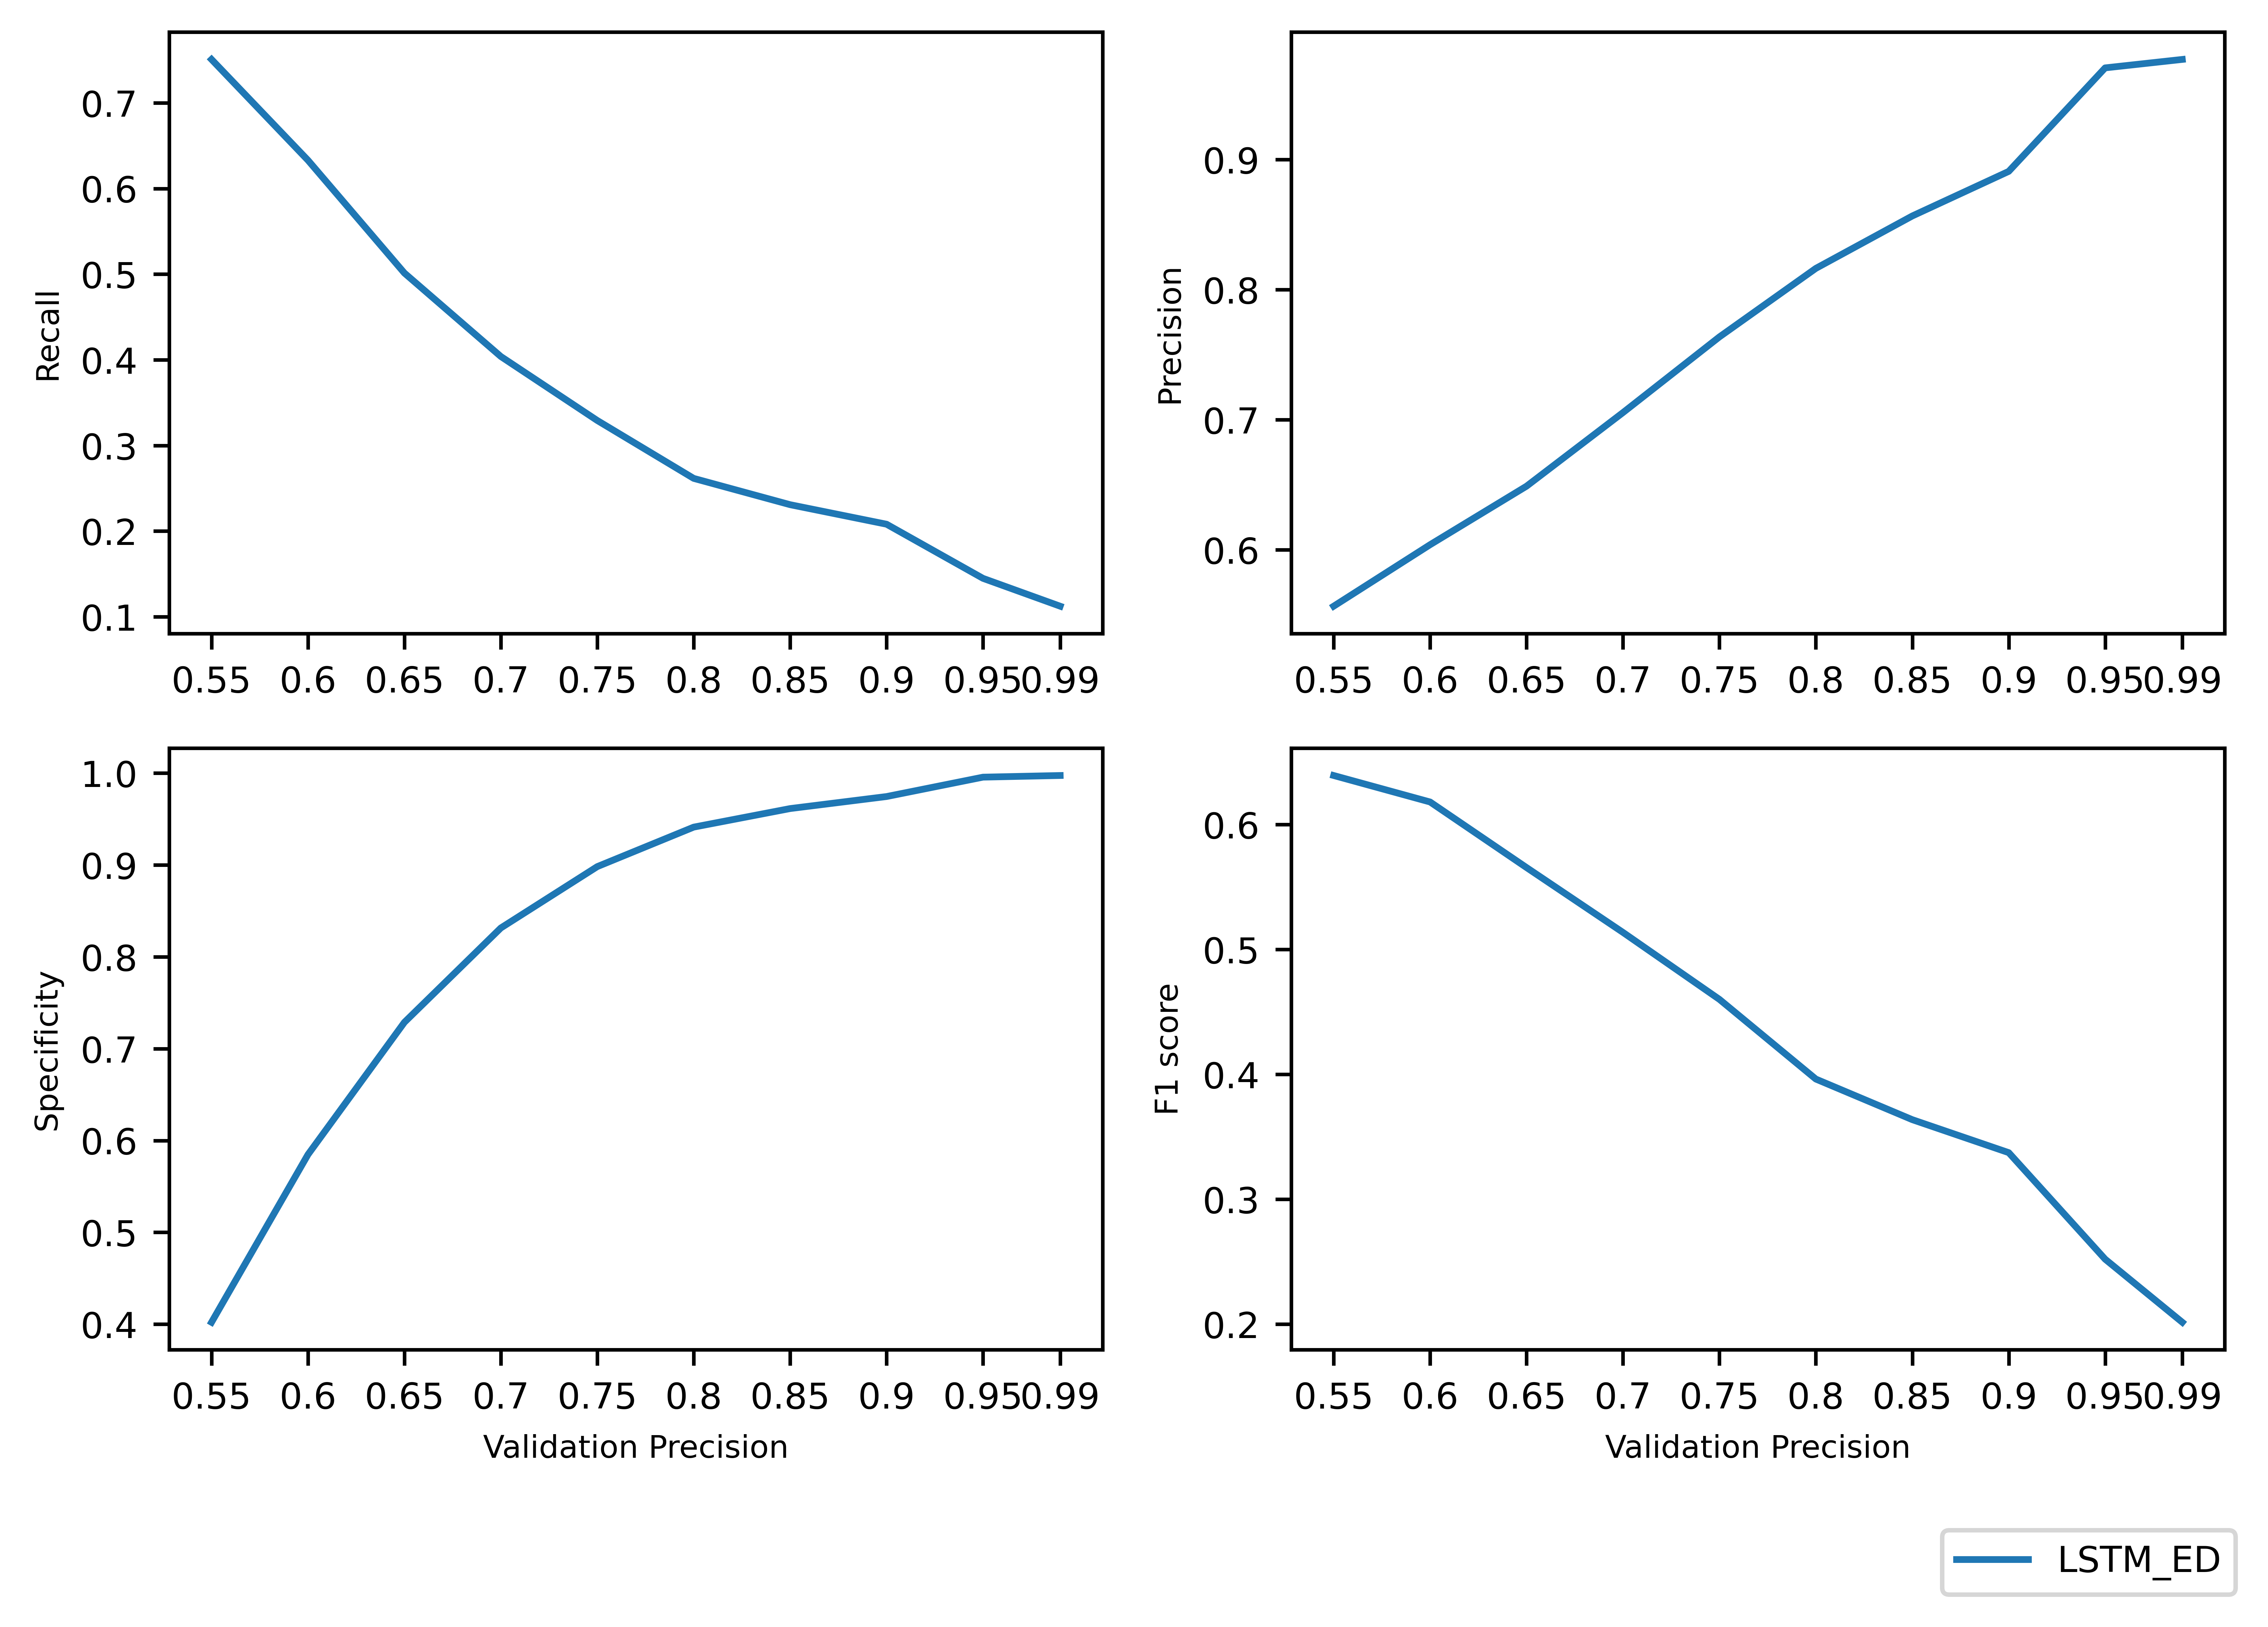

In [30]:
plt.style.use('default')

plt.rcParams['font.family'] = 'Times New Roman'
plt.rc('font',size=10)
plt.rc('xtick',labelsize=8)
plt.rc('ytick',labelsize=8)
cmap_name = 'tab20'
fig, ax= plt.subplots(2, 2, figsize=(18/2.54, 12/2.54))
fig.set_dpi(1000)

for ax_idx, perf_measure in enumerate([i for i in ['rec', 'prec', 'spec', 'f1']]):
    tmp = comparison_data
    label = 'lstm_ed'
    
    ax[ax_idx//2, ax_idx%2].plot(prec_cfs, tmp[perf_measure], label=label.upper(), color=plt.cm.get_cmap(cmap_name)(0))
    plt.xticks(prec_cfs)
    if perf_measure == 'rec':
        title = 'Recall'
    elif perf_measure == 'prec':
        title = 'Precision'
    elif perf_measure == 'f1':
        title = 'F1 score'
    elif perf_measure == 'spec':
        title = 'Specificity'

    ax[ax_idx//2, ax_idx%2].set_ylabel(title, fontsize=7)
    ax[ax_idx//2, ax_idx%2].set_xticks(prec_cfs)
    ax[ax_idx//2, ax_idx%2].set_xticklabels(prec_cfs)
    if ax_idx//2 == 1:
        ax[ax_idx//2, ax_idx%2].set_xlabel('Validation Precision', fontsize=7)
        
handles, labels = plt.gca().get_legend_handles_labels()
fig.legend(handles, labels, bbox_to_anchor=(0.99,0), fontsize=8, frameon=True)

plt.tight_layout()

In [57]:
plt.style.use('default')

#plt.rcParams['font.family'] = 'Times New Roman'
plt.rc('font',size=10)
plt.rc('xtick',labelsize=8)
plt.rc('ytick',labelsize=8)
cmap_name = 'tab20'
fig, ax= plt.subplots(3, 1, figsize=(5, 10))
fig.set_dpi(1000)


for ax_idx, perf_measure in enumerate([i for i in ['fa', 'att', 'pr']]):
        tmp = comparison_data
        label = 'lstm_ed'
    
        ax[ax_idx].plot(prec_cfs, tmp[perf_measure], label=label.upper(), color=plt.cm.get_cmap(cmap_name)(0))
        plt.xticks(prec_cfs)

        ax[ax_idx].set_ylabel(perf_measure.upper(), fontsize=10)
        ax[ax_idx].set_xticks(prec_cfs)
        ax[ax_idx].set_xticklabels(prec_cfs)
        if ax_idx == 2:
            ax[ax_idx].set_xlabel('Validation Precision', fontsize=7)
        
handles, labels = plt.gca().get_legend_handles_labels()
fig.legend(handles, labels, bbox_to_anchor=(0.99,0), fontsize=6, frameon=True)

plt.tight_layout()

/tmp/ipykernel_3065422/988543961.py:16: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  ax[ax_idx].plot(prec_cfs, tmp[perf_measure], label=label.upper(), color=plt.cm.get_cmap(cmap_name)(0))
/tmp/ipykernel_3065422/988543961.py:16: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  ax[ax_idx].plot(prec_cfs, tmp[perf_measure], label=label.upper(), color=plt.cm.get_cmap(cmap_name)(0))
/tmp/ipykernel_3065422/988543961.py:16: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  ax[ax_idx].plot(p

In [ ]:
import pandas as pd
import numpy as np
from tqdm import tqdm

def conf_mat(true, pred):
    tp = ((pred == 1) & (true == 1)).sum()
    fp = ((pred == 1) & (true == 0)).sum()
    fn = ((pred == 0) & (true == 1)).sum()
    tn = ((pred == 0) & (true == 0)).sum()
    return tp, fp, fn, tn

ver=1
low_esi = 1
comp_data = pd.read_csv('comparison_data-low_esi1-1-no_hpt.csv')
cutoff = comp_data.query('model=="lstm_ae" & prec_cf==0.75')['model_cutoff'].values[0]


eval_results = []
for eval_split in ['val_th', 'tst']:
    eval_result = []
    eval_data = pd.read_csv(f"eval_data-low_esi{ver}-{low_esi}-lstm_ae-{eval_split}.csv")

    eval_data['pred'] = np.where(eval_data['score']>=cutoff, 1, 0)
    eval_result = eval_data.groupby('id').agg({'true': lambda x: x.values[0], 'pred': 'max'}).reset_index()

    eval_results.append(eval_result)

eval_results = pd.concat(eval_results).reset_index(drop=True)

eval_results.to_csv('eval_result-lstm_ae-low_esi1-1-no_hpt.csv', index=False)